# Video Pre-processing
- Video cropper
- Video trimmer
- Video key frame detection

## Video cropper

In [16]:
import cv2
import os
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox

class VideoTrimmer:
    def __init__(self, master):
        self.master = master
        self.master.title("Video Trimmer and Frame Reader")

        self.file_path = tk.StringVar()

        self.load_button = tk.Button(self.master, text="Load Video", command=self.load_video)
        self.load_button.pack()

        self.trim_button = tk.Button(self.master, text="Trim Video", command=self.trim_video, state=tk.DISABLED)
        self.trim_button.pack()

        self.read_frame_button = tk.Button(self.master, text="Read Frame", command=self.read_frame, state=tk.DISABLED)
        self.read_frame_button.pack()

    def load_video(self):
        file_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4;*.avi;*.mkv")])
        if file_path:
            self.file_path.set(file_path)
            self.trim_button.config(state=tk.NORMAL)
            self.read_frame_button.config(state=tk.NORMAL)

    def trim_video(self):
        if self.file_path.get():
            start_time = float(input("Enter the start time (in seconds): "))
            end_time = float(input("Enter the end time (in seconds): "))

            input_video = cv2.VideoCapture(self.file_path.get())
            fps = int(input_video.get(cv2.CAP_PROP_FPS))
            fourcc = int(input_video.get(cv2.CAP_PROP_FOURCC))

            input_directory, input_filename = os.path.split(self.file_path.get())
            input_filename_no_ext = os.path.splitext(input_filename)[0]
            output_file_path = os.path.join(input_directory, input_filename_no_ext + '_trim' + os.path.splitext(input_filename)[1])

            output_video = cv2.VideoWriter(output_file_path, fourcc, fps, (int(input_video.get(3)), int(input_video.get(4))))

            start_frame = int(start_time * fps)
            end_frame = int(end_time * fps)

            current_frame = 0
            while input_video.isOpened():
                ret, frame = input_video.read()
                if not ret:
                    break

                if start_frame <= current_frame <= end_frame:
                    output_video.write(frame)

                current_frame += 1
                if current_frame > end_frame:
                    break

            input_video.release()
            output_video.release()
            messagebox.showinfo("Video Trimmer", f"Trimmed video saved as {output_file_path}")

    def read_frame(self):
        if self.file_path.get():
            frame_number = int(input("Enter the frame number: "))
            input_video = cv2.VideoCapture(self.file_path.get())
            input_video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = input_video.read()
            if ret:
                cv2.imshow(f"Frame {frame_number}", frame)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
            else:
                messagebox.showerror("Error", f"Could not read frame {frame_number}")

            input_video.release()

if __name__ == "__main__":
    root = tk.Tk()
    app = VideoTrimmer(root)
    root.mainloop()


Enter the start time (in seconds): 15
Enter the end time (in seconds): 25
Enter the start time (in seconds): 10
Enter the end time (in seconds): 15


## Video trimmer

In [2]:
import cv2
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
from PIL import Image, ImageTk


def browse_video():
    global input_video
    file_path = filedialog.askopenfilename()
    input_video = cv2.VideoCapture(file_path)
    update_frame()


def update_frame():
    global input_video
    ret, frame = input_video.read()

    if not ret:
        input_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = input_video.read()

    frame = cv2.resize(frame, (600, 400))
    frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA))
    frame = ImageTk.PhotoImage(image=frame)

    video_label.config(image=frame)
    video_label.image = frame
    video_label.after(10, update_frame)


def save_adjusted_video():
    global input_video
    file_path = filedialog.asksaveasfilename(defaultextension=".avi")
    if not file_path:
        return

    codec = int(input_video.get(cv2.CAP_PROP_FOURCC))
    fps = int(input_video.get(cv2.CAP_PROP_FPS))
    frame_size = (int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    output_video = cv2.VideoWriter(file_path, codec, fps, frame_size)

    input_video.set(cv2.CAP_PROP_POS_FRAMES, 0)

    while True:
        ret, frame = input_video.read()
        if not ret:
            break

        frame = cv2.convertScaleAbs(frame, alpha=contrast_scale.get(), beta=brightness_scale.get())

        output_video.write(frame)

    output_video.release()
    messagebox.showinfo("Success", "Video adjustments saved successfully")


root = tk.Tk()
root.title("Video Adjuster")

frame = tk.Frame(root)
frame.pack(padx=10, pady=10)

video_label = tk.Label(frame)
video_label.grid(row=0, column=0, columnspan=2)

browse_button = tk.Button(frame, text="Browse Video", command=browse_video)
browse_button.grid(row=1, column=0, pady=5)

save_button = tk.Button(frame, text="Save Adjusted Video", command=save_adjusted_video)
save_button.grid(row=1, column=1, pady=5)

contrast_label = tk.Label(frame, text="Contrast:")
contrast_label.grid(row=2, column=0)

brightness_label = tk.Label(frame, text="Brightness:")
brightness_label.grid(row=3, column=0)

contrast_scale = tk.Scale(frame, from_=0.5, to=3.0, resolution=0.1, orient=tk.HORIZONTAL)
contrast_scale.set(1.0)
contrast_scale.grid(row=2, column=1)

brightness_scale = tk.Scale(frame, from_=-100, to=100, resolution=1, orient=tk.HORIZONTAL)
brightness_scale.set(0)
brightness_scale.grid(row=3, column=1)

input_video = None
root.mainloop()


## Video key frame detection

In [ ]:
import cv2
import numpy as np
from tkinter import filedialog
from tkinter import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


def load_video():
    file_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4;*.avi;*.mov")])
    if not file_path:
        return

    global cap
    cap = cv2.VideoCapture(file_path)
    global total_frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    track_bar.configure(to=total_frames - 1)
    update_frame(0)


def update_frame(value):
    value = int(value)
    cap.set(cv2.CAP_PROP_POS_FRAMES, value)
    ret, frame = cap.read()
    global current_frame
    current_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow("Frame", current_frame)


def on_mouse(event, x, y, flags, param):
    global roi
    if event == cv2.EVENT_LBUTTONDOWN:
        roi = [(x, y)]
    elif event == cv2.EVENT_LBUTTONUP:
        roi.append((x, y))
        cv2.rectangle(current_frame, roi[0], roi[1], (0, 255, 0), 2)
        cv2.imshow("Frame", current_frame)


def select_roi():
    cv2.setMouseCallback("Frame", on_mouse)


def calculate_average_gray():
    if not cap or not roi:
        return

    x1, y1 = roi[0]
    x2, y2 = roi[1]

    gray_values = np.zeros(total_frames)
    for i in range(total_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        roi_gray = gray_frame[y1:y2, x1:x2]
        avg_gray = np.max(roi_gray)
        gray_values[i] = avg_gray

    plot(gray_values)


def plot(gray_values):
    fig, ax = plt.subplots()
    frame_numbers = range(total_frames)
    ax.plot(frame_numbers, gray_values)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Gray Value")
    ax.set_title("Average Gray Value of ROI")

    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=BOTH, expand=1)


root = Tk()
root.title("Video Analyzer")

load_video_button = Button(root, text="Load Video", command=load_video)
load_video_button.pack()

track_bar = Scale(root, orient=HORIZONTAL, command=update_frame)
track_bar.pack()

select_roi_button = Button(root, text="Select ROI", command=select_roi)
select_roi_button.pack()

calculate_button = Button(root, text="Calculate Average Gray Value", command=calculate_average_gray)
calculate_button.pack()

cap = None
total_frames = 0
current_frame = None
roi = []

root.mainloop()
cap.release()
cv2.destroyAllWindows()


In [59]:
import cv2
import numpy as np
from tkinter import filedialog
from tkinter import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading


def load_video():
    file_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4;*.avi;*.mov")])
    if not file_path:
        return

    global cap
    cap = cv2.VideoCapture(file_path)
    global total_frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    track_bar.configure(to=total_frames - 1)
    update_frame(0)


def update_frame(value):
    value = int(value)
    cap.set(cv2.CAP_PROP_POS_FRAMES, value)
    ret, frame = cap.read()
    global current_frame
    current_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow("Frame", current_frame)


def on_mouse(event, x, y, flags, param):
    global roi
    if event == cv2.EVENT_LBUTTONDOWN:
        roi = [(x, y)]
    elif event == cv2.EVENT_LBUTTONUP:
        roi.append((x, y))
        cv2.rectangle(current_frame, roi[0], roi[1], (0, 255, 0), 2)
        cv2.imshow("Frame", current_frame)


def select_roi():
    cv2.setMouseCallback("Frame", on_mouse)


def process_frame(i, gray_values):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    roi_gray = gray_frame[y1:y2, x1:x2]
    avg_gray = np.mean(roi_gray)
    gray_values[i] = avg_gray

def calculate_average_gray():
    if not cap or not roi:
        return

    x1, y1 = roi[0]
    x2, y2 = roi[1]

    gray_values = np.zeros(total_frames)
    threads = []

    for i in range(total_frames):
        t = threading.Thread(target=process_frame, args=(i, gray_values))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    plot(gray_values)


def plot(gray_values):
    fig, ax = plt.subplots()
    frame_numbers = range(total_frames)
    ax.plot(frame_numbers, gray_values)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Gray Value")
    ax.set_title("Average Gray Value of ROI")

    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=BOTH, expand=1)


root = Tk()
root.title("Video Analyzer")

load_video_button = Button(root, text="Load Video", command=load_video)
load_video_button.pack()

track_bar = Scale(root, orient=HORIZONTAL, command=update_frame)
track_bar.pack()

select_roi_button = Button(root, text="Select ROI", command=select_roi)
select_roi_button.pack()

calculate_button = Button(root, text="Calculate Average Gray Value", command=calculate_average_gray)
calculate_button.pack()

cap = None
total_frames = 0
current_frame = None
roi = []

root.mainloop()
cap.release()
cv2.destroyAllWindows()


AttributeError: 'NoneType' object has no attribute 'release'

# Video frame grabber

In [53]:
import cv2
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np

class VideoFrameGrabber:
    def __init__(self, root):
        self.root = root
        self.root.title("Video Frame Grabber")
        self.vid = None
        self.frame = None
        self.total_frames = 0

        # Canvas for video, initialized with default size.
        self.canvas = tk.Canvas(root, width=500, height=500)
        self.canvas.pack()

        # Frame slider
        self.slider = tk.Scale(root, from_=0, to=1, orient='horizontal', length=500, command=self.get_frame)
        self.slider.pack(fill='x')

        # Buttons
        self.btn_load = tk.Button(root, text="Load Video", command=self.load_video)
        self.btn_load.pack(fill='x')

        self.btn_capture = tk.Button(root, text="Capture Frame", command=self.capture_frame)
        self.btn_capture.pack(fill='x')

        # Call update function to start the loop for video frame reading
        self.update()

    def load_video(self):
        self.filename = filedialog.askopenfilename(title="Select a video file", filetypes=(("MP4 files", "*.mp4"), ("All files", "*.*")))
        self.vid = cv2.VideoCapture(self.filename)
        self.total_frames = int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT))
        self.slider.config(to=self.total_frames)
        self.get_frame(0)  # Initialize with first frame

        # Resize the canvas to fit the video
        width = self.vid.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = self.vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
        self.canvas.config(width=int(width), height=int(height))

    def capture_frame(self):
        if self.frame is not None:
            # Parse the filename and construct the name for the frame
            video_path_parts = self.filename.split("\\")
            video_name_parts = video_path_parts[-1].split(".")[:-1]  # Exclude extension

            if len(video_path_parts) >= 3:
                video_name_parts.insert(0, video_path_parts[-3])  # Add folder name '322'

            frame_name = "_".join(video_name_parts) + ".png"

            cv2.imwrite(frame_name, cv2.cvtColor(self.frame, cv2.COLOR_RGB2BGR))
            messagebox.showinfo("Frame Saved", f"The current frame has been saved as {frame_name} in your current directory.")
        else:
            messagebox.showwarning("Warning", "No frame to save. Please load a video.")

    def get_frame(self, current_frame):
        if self.vid is not None:
            self.vid.set(cv2.CAP_PROP_POS_FRAMES, int(current_frame))
            _, self.frame = self.vid.read()
            self.frame = cv2.cvtColor(self.frame, cv2.COLOR_BGR2RGB)
            self.photo = ImageTk.PhotoImage(image=Image.fromarray(self.frame))
            self.canvas.create_image(0, 0, image=self.photo, anchor=tk.NW)

    def update(self):
        self.root.after(1, self.update)  # Call update function after 1 ms

# Create a window and pass it to the VideoFrameGrabber object
root = tk.Tk()
app = VideoFrameGrabber(root)
root.mainloop()


# Video frame overlapper

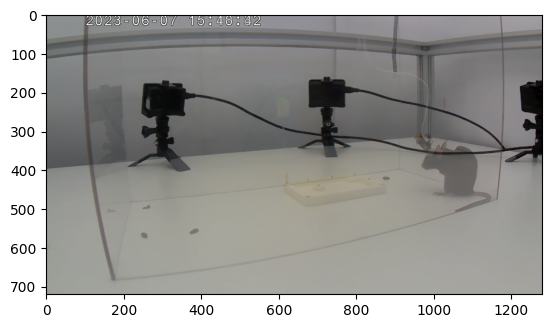

The overlay image has been saved as H:\DANNCE\6cam_behavior\332\cam6\overlay_20230607_151002A.png_20230607_154003A.png.png.


In [9]:
import cv2
import numpy as np
import glob
import os
from matplotlib import pyplot as plt

def overlay_images(image_path1, image_path2, alpha=0.5):
    
    # Read the images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    # Make sure the images are the same size
    if image1.shape != image2.shape:
        print("Images are not the same size. Resizing...")
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # Calculate the weighted sum of the input images
    overlay = cv2.addWeighted(image1, alpha, image2, 1 - alpha, 0)

    # Display the overlay image inline using matplotlib
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.show()

    # Construct the overlay image filename
    overlay_filename = os.path.join(os.path.dirname(image_path1), f"overlay_{os.path.basename(image_path1)}_{os.path.basename(image_path2)}.png")

    # Save the overlay image
    cv2.imwrite(overlay_filename, overlay)

    print(f"The overlay image has been saved as {overlay_filename}.")

# Directory where the PNG files are stored
directory = r"H:\DANNCE\6cam_behavior\332\cam6"

# Find all PNG files in the directory
png_files = sorted(glob.glob(os.path.join(directory, "*.png")))

# Overlay each consecutive pair of images

for i in range(len(png_files) - 1):
    overlay_images(png_files[i], png_files[i+1])


# ROI red value calculator

In [2]:
import os
import cv2
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
import time

class VideoFrameGrabber:
    def __init__(self, root):
        self.root = root
        self.root.title("Video Frame Grabber")
        self.vid = None
        self.frame = None
        self.total_frames = 0
        self.current_frame = 0
        self.roi_start = None
        self.roi_end = None
        self.roi_values = []

        # Canvas for video, initialized with default size.
        self.canvas = tk.Canvas(root, width=500, height=500)
        self.canvas.pack()

        # Frame slider
        self.slider = tk.Scale(root, from_=0, to=1, orient='horizontal', length=500, command=self.get_frame)
        self.slider.pack(fill='x')

        # Buttons
        self.btn_load = tk.Button(root, text="Load Video", command=self.load_video)
        self.btn_load.pack(fill='x')

        self.btn_label_roi = tk.Button(root, text="Label ROI", command=self.label_roi)
        self.btn_label_roi.pack(fill='x')

        # Call update function to start the loop for video frame reading
        self.update()

    def load_video(self):
        self.filename = filedialog.askopenfilename(title="Select a video file", filetypes=(("MP4 files", "*.mp4"), ("All files", "*.*")))
        # Store the base name without extension
        self.basename_without_ext = os.path.splitext(os.path.basename(self.filename))[0]
        self.vid = cv2.VideoCapture(self.filename)
        self.total_frames = int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT))
        self.slider.config(to=self.total_frames)
        self.get_frame(0)  # Initialize with first frame

        # Resize the canvas to fit the video
        width = self.vid.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = self.vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
        self.canvas.config(width=int(width), height=int(height))

    def label_roi(self):
        if self.frame is not None:
            # Reset the ROI and ROI values
            self.roi_start = None
            self.roi_end = None
            self.roi_values = []

            # Bind mouse events
            self.canvas.bind("<ButtonPress-1>", self.on_mouse_press)
            self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
            self.canvas.bind("<ButtonRelease-1>", self.on_mouse_release)

        else:
            messagebox.showwarning("Warning", "No frame to label. Please load a video.")

    def on_mouse_press(self, event):
        self.roi_start = (event.x, event.y)

    def on_mouse_drag(self, event):
        self.roi_end = (event.x, event.y)
        self.draw_roi()

    def on_mouse_release(self, event):
        self.roi_end = (event.x, event.y)
        self.draw_roi()
        self.canvas.unbind("<ButtonPress-1>")
        self.canvas.unbind("<B1-Motion>")
        self.canvas.unbind("<ButtonRelease-1>")

        # Calculate average gray value in ROI for each frame
        if self.vid is not None and self.roi_start is not None and self.roi_end is not None:
            self.vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
            ret, frame = self.vid.read()
            frame_count = 0
            start_time = time.time()

            while ret:
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                roi_frame = gray_frame[self.roi_start[1]:self.roi_end[1], self.roi_start[0]:self.roi_end[0]]
                avg_gray = np.mean(roi_frame)
                self.roi_values.append(avg_gray)

                ret, frame = self.vid.read()
                frame_count += 1

                if frame_count % 10000 == 0:
                    elapsed_time = time.time() - start_time
                    print(f"Time spent: {elapsed_time * 1000:.2f} ms | Current Frame: {frame_count} / {self.total_frames}")

            # Plot time series data
            frame_numbers = np.arange(frame_count)
            plt.plot(frame_numbers, self.roi_values)
            plt.xlabel('Frame Number')
            plt.ylabel('Average Gray Value')
            plt.title(f"{self.basename_without_ext} ROI Average Gray Value over Time")
            plt.show()

            # Save time series data as NumPy array
            data_array = np.array(self.roi_values)
            save_path = f"{self.basename_without_ext}_gray_event.npy"
            np.save(save_path, data_array)

    def draw_roi(self):
        self.canvas.delete("roi_rectangle")
        if self.roi_start is not None and self.roi_end is not None:
            self.canvas.create_rectangle(self.roi_start[0], self.roi_start[1], self.roi_end[0], self.roi_end[1],
                                         outline="green", width=2, tags="roi_rectangle")

    def get_frame(self, current_frame):
        self.current_frame = int(current_frame)
        if self.vid is not None:
            self.vid.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
            _, self.frame = self.vid.read()
            self.frame = cv2.cvtColor(self.frame, cv2.COLOR_BGR2RGB)
            self.photo = ImageTk.PhotoImage(image=Image.fromarray(self.frame))
            self.canvas.create_image(0, 0, image=self.photo, anchor=tk.NW)

    def update(self):
        self.slider.set(self.current_frame)
        self.root.after(1, self.update)  # Call update function after 1 ms

# Create a window and pass it to the VideoFrameGrabber object
root = tk.Tk()
app = VideoFrameGrabber(root)
root.mainloop()


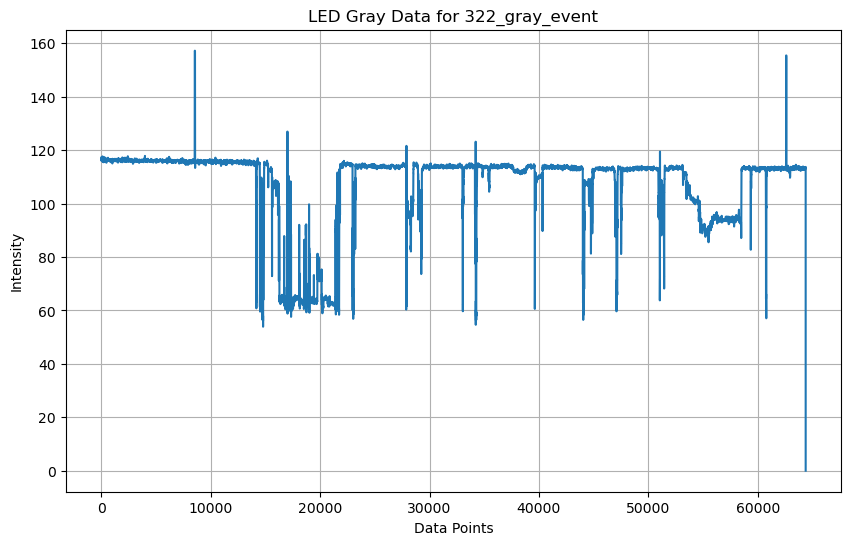

Please set the threshold for 322_gray_event based on the plot (e.g., 170): 140


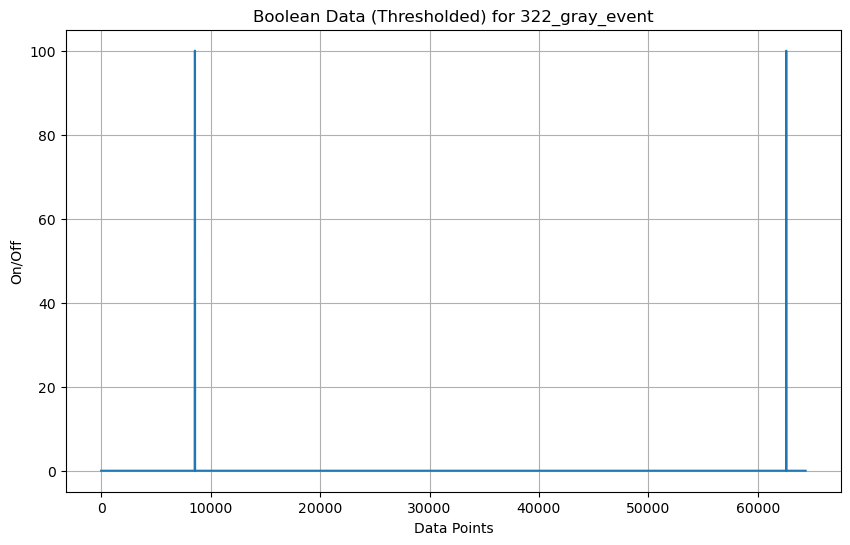

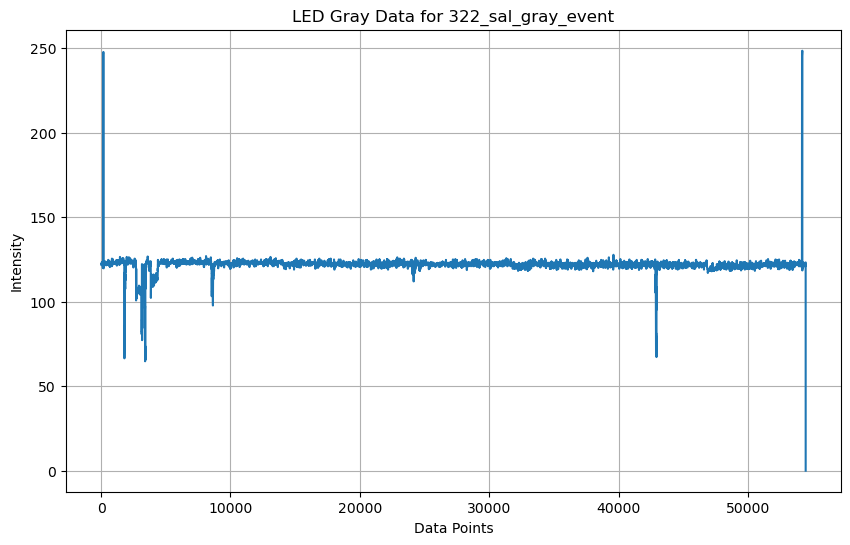

Please set the threshold for 322_sal_gray_event based on the plot (e.g., 170): 200


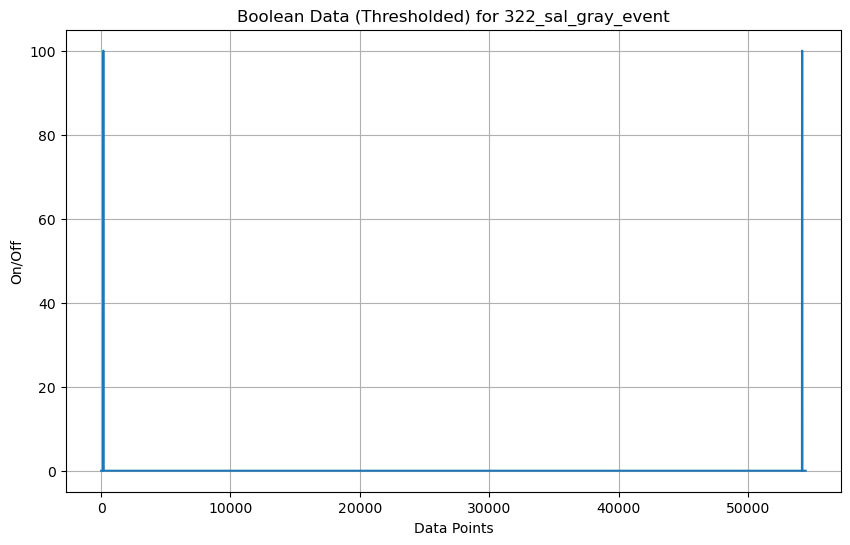

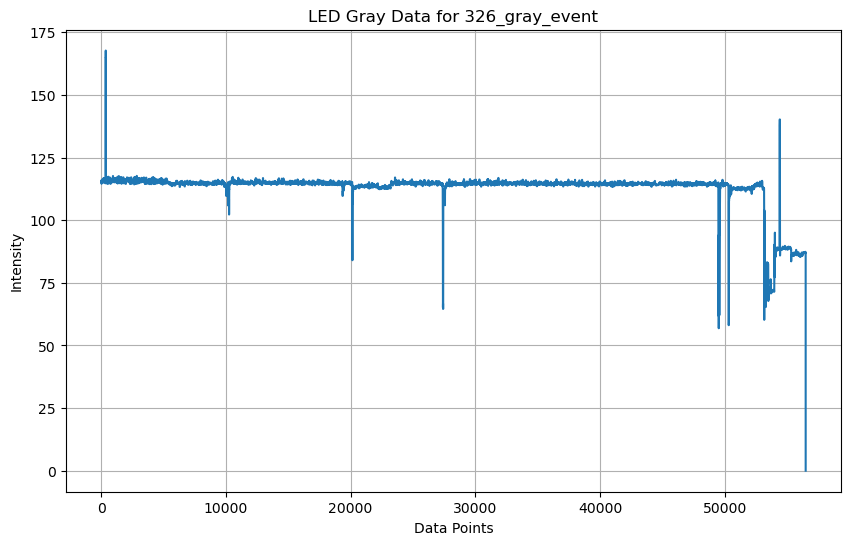

Please set the threshold for 326_gray_event based on the plot (e.g., 170): 125


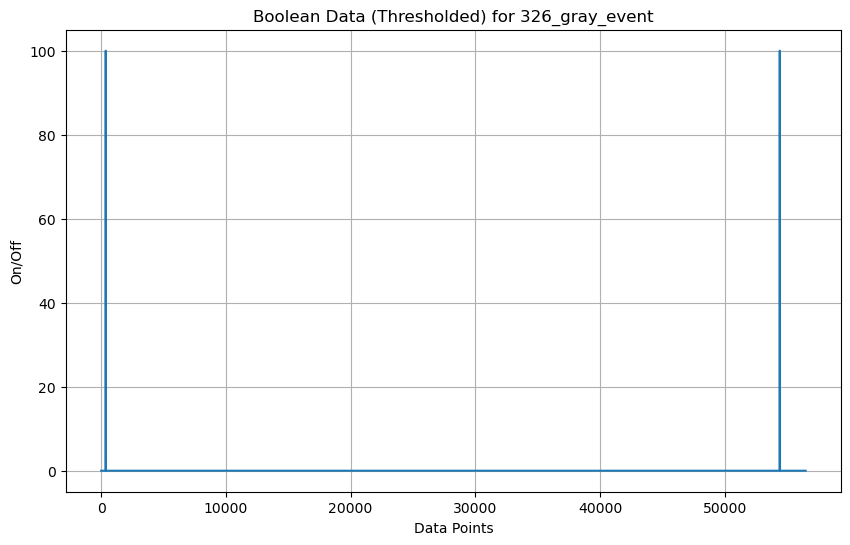

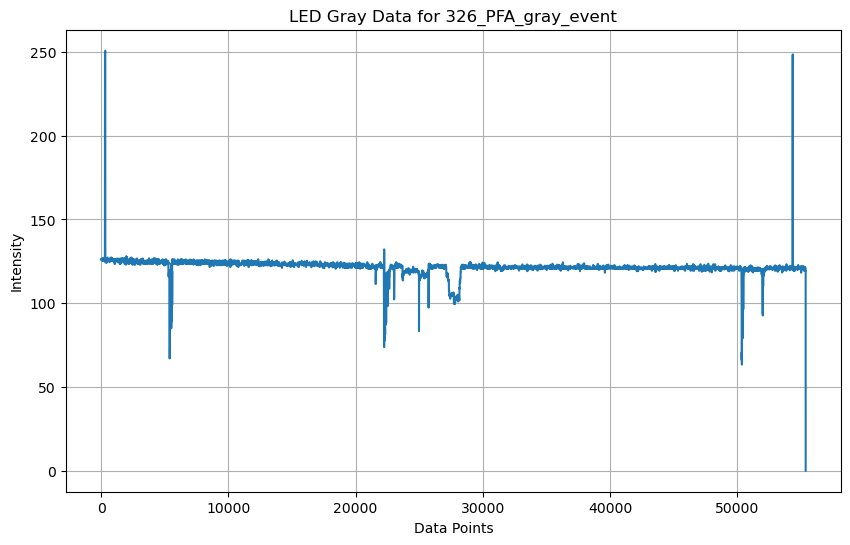

Please set the threshold for 326_PFA_gray_event based on the plot (e.g., 170): 200


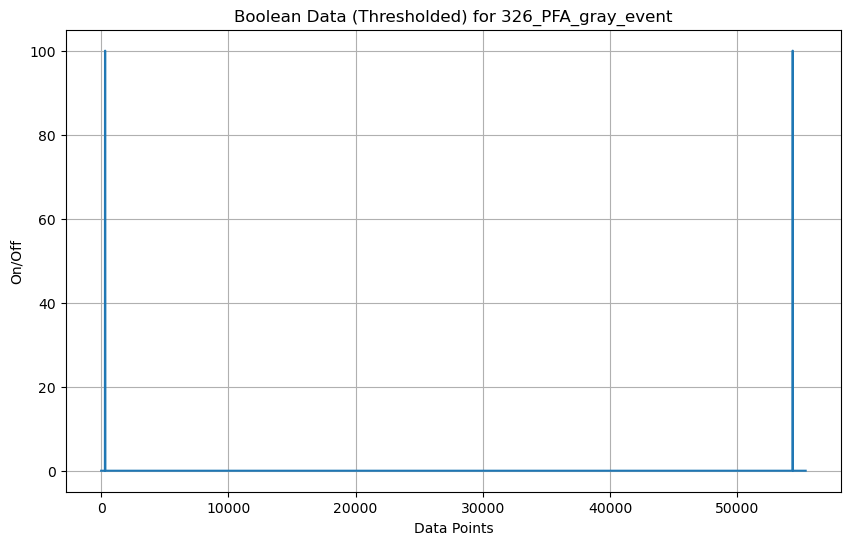

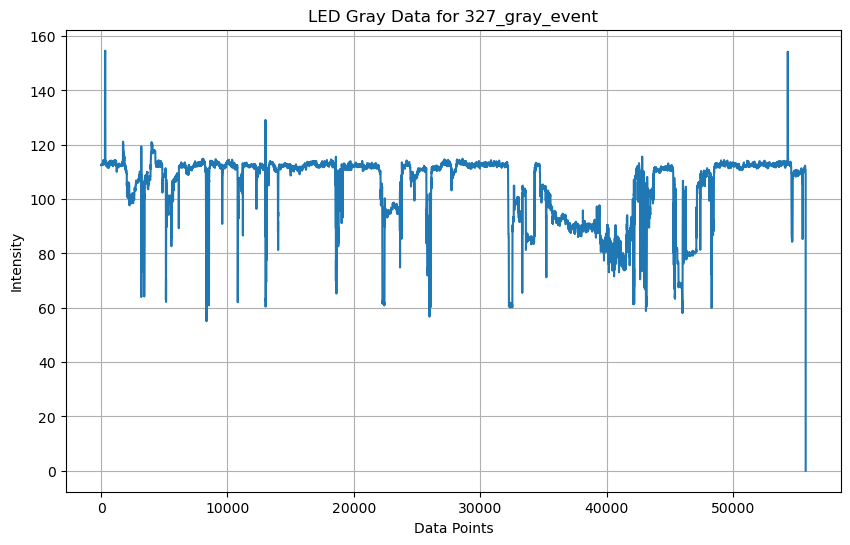

Please set the threshold for 327_gray_event based on the plot (e.g., 170): 140


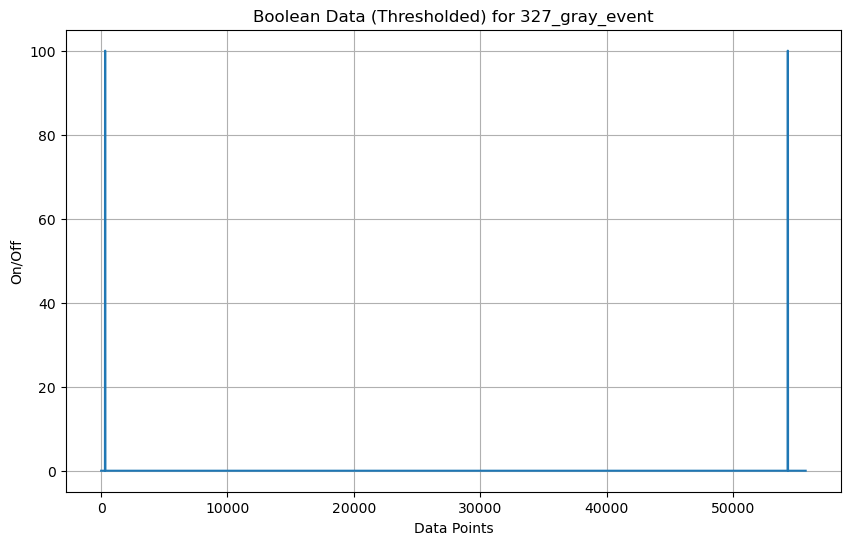

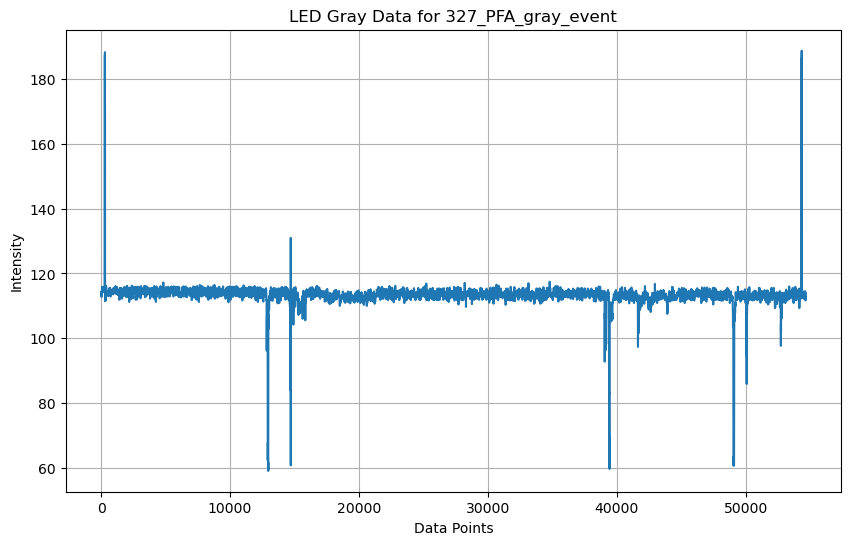

Please set the threshold for 327_PFA_gray_event based on the plot (e.g., 170): 180


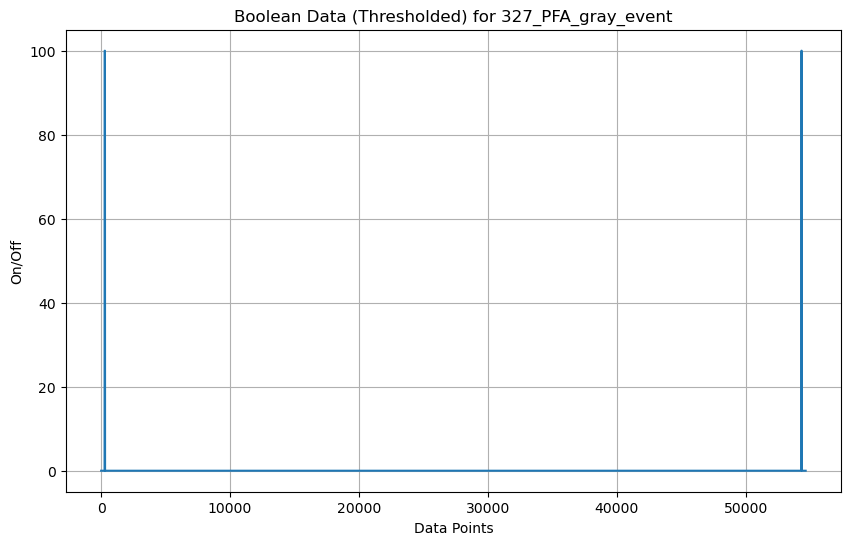

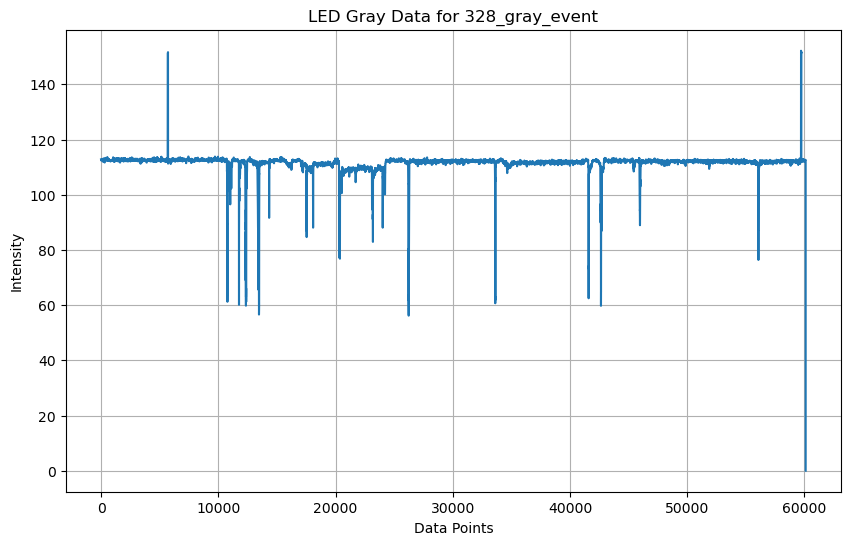

Please set the threshold for 328_gray_event based on the plot (e.g., 170): 140


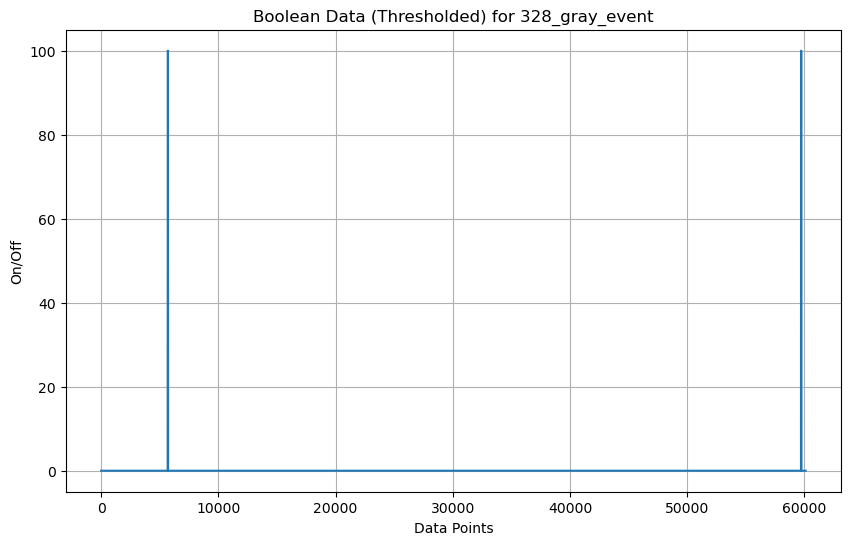

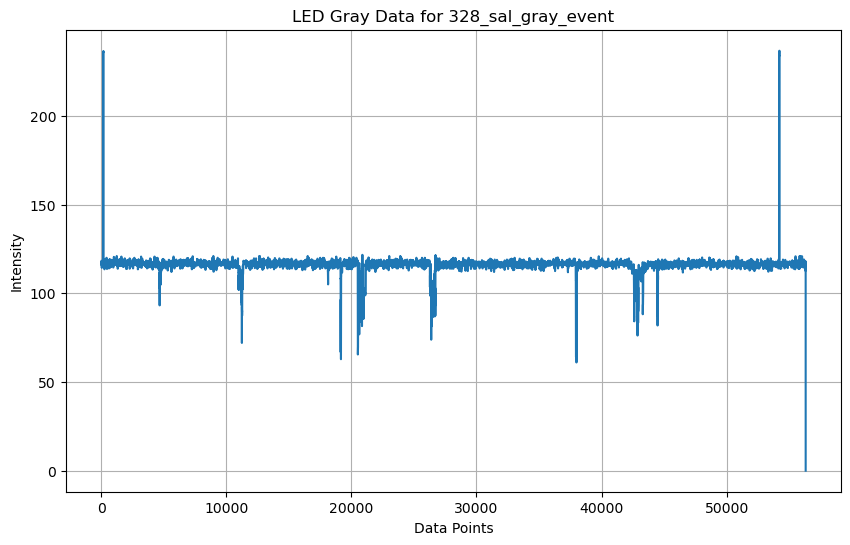

Please set the threshold for 328_sal_gray_event based on the plot (e.g., 170): 200


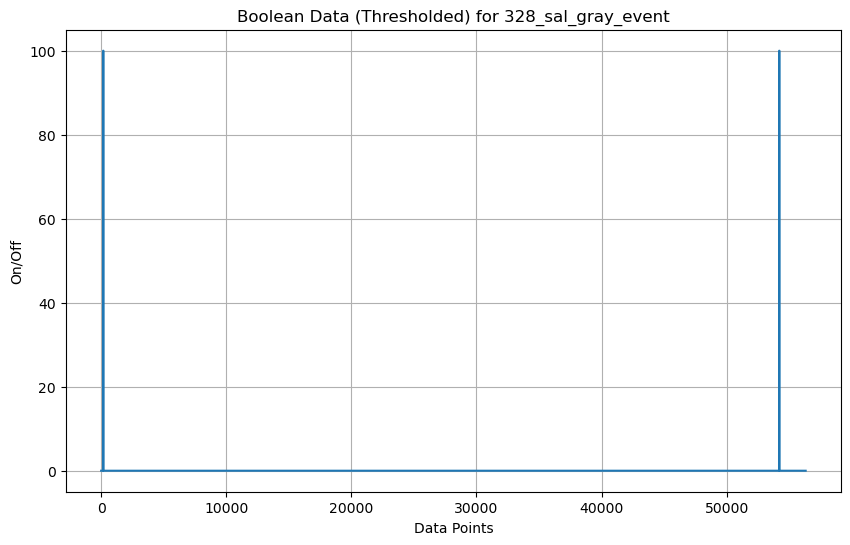

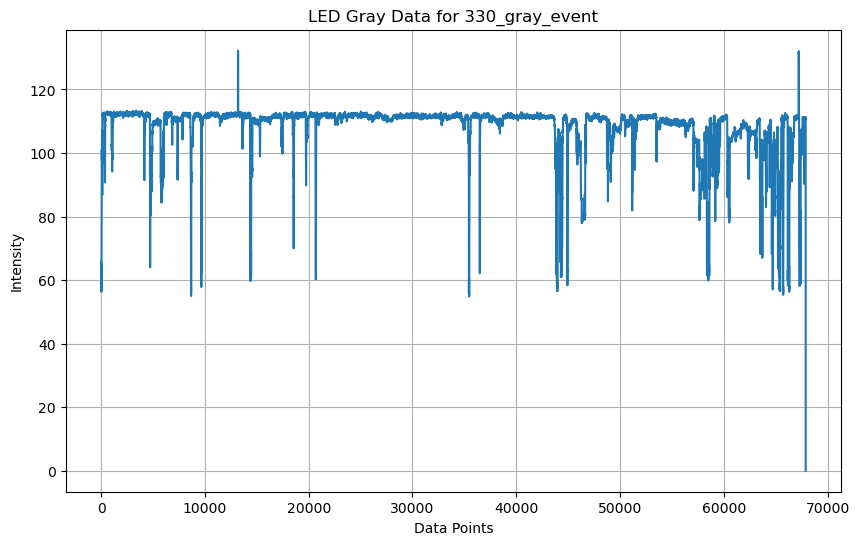

Please set the threshold for 330_gray_event based on the plot (e.g., 170): 120


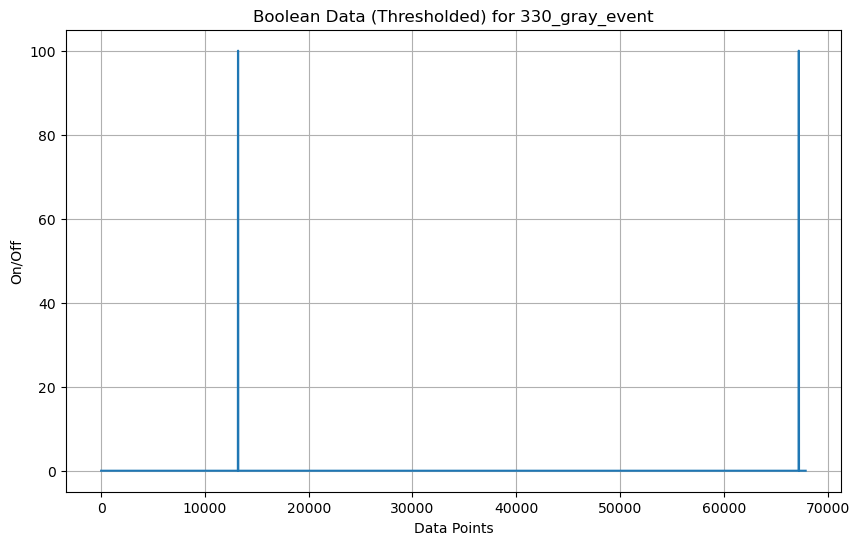

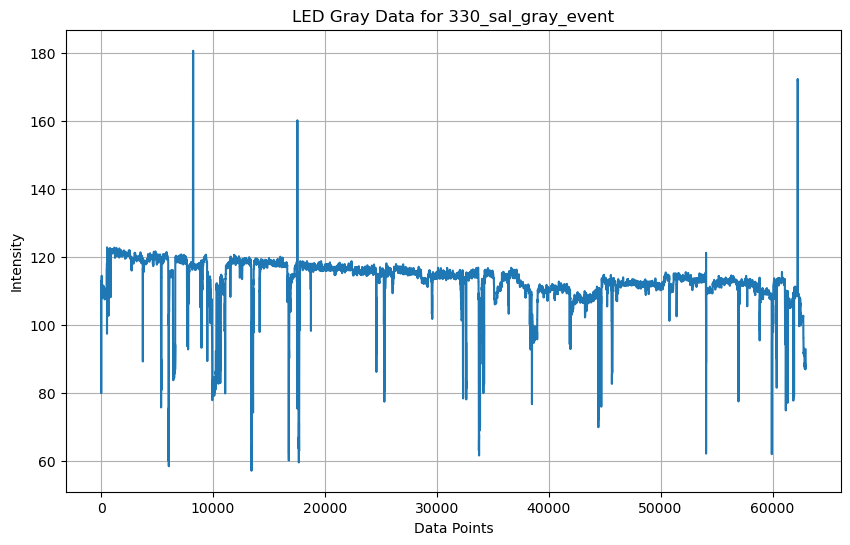

Please set the threshold for 330_sal_gray_event based on the plot (e.g., 170): 165


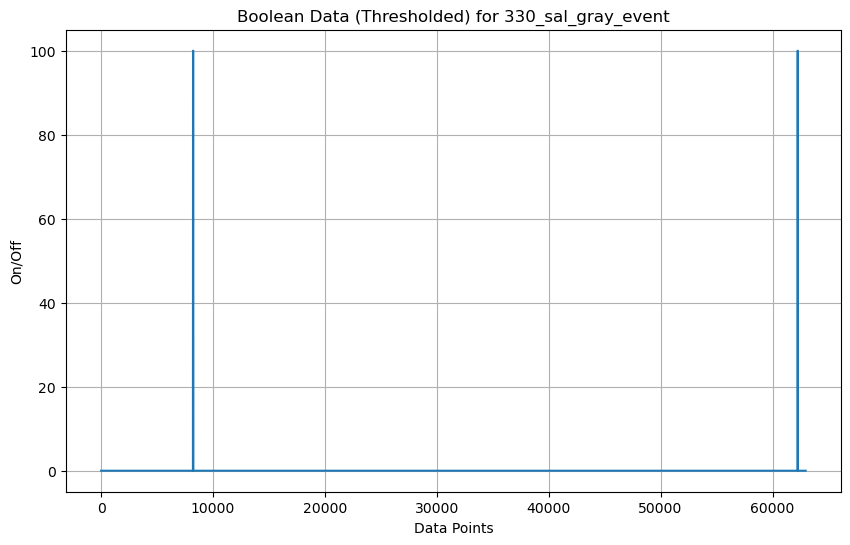

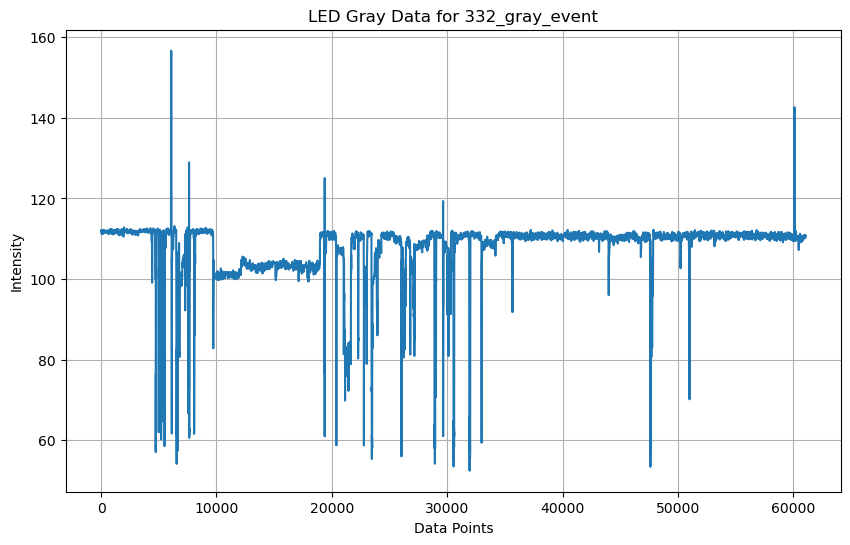

Please set the threshold for 332_gray_event based on the plot (e.g., 170): 140


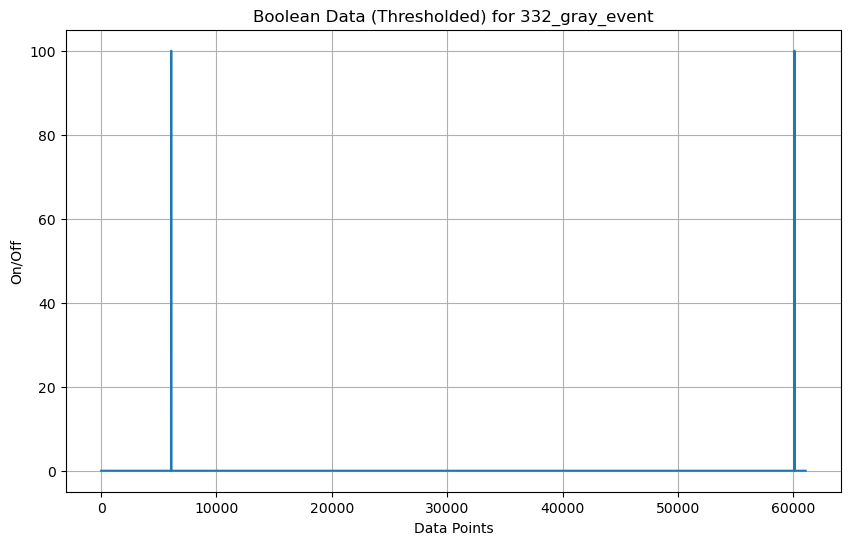

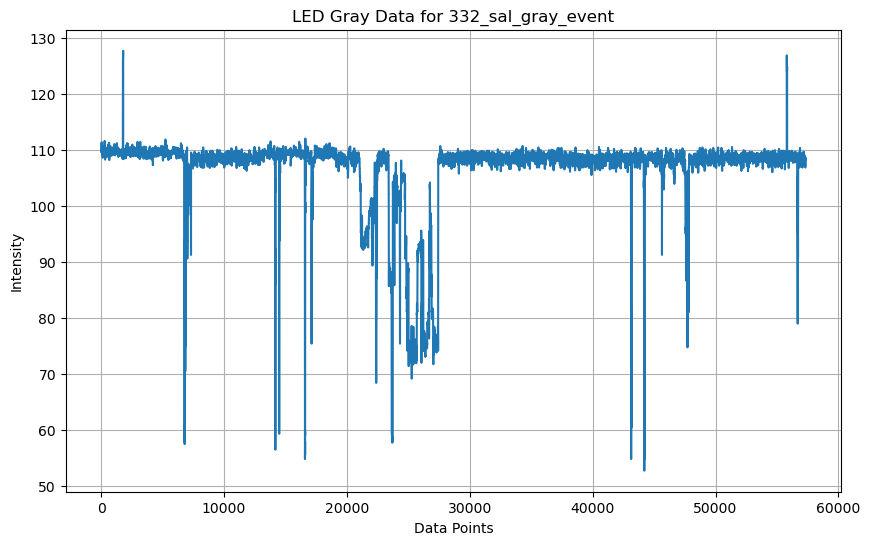

Please set the threshold for 332_sal_gray_event based on the plot (e.g., 170): 120


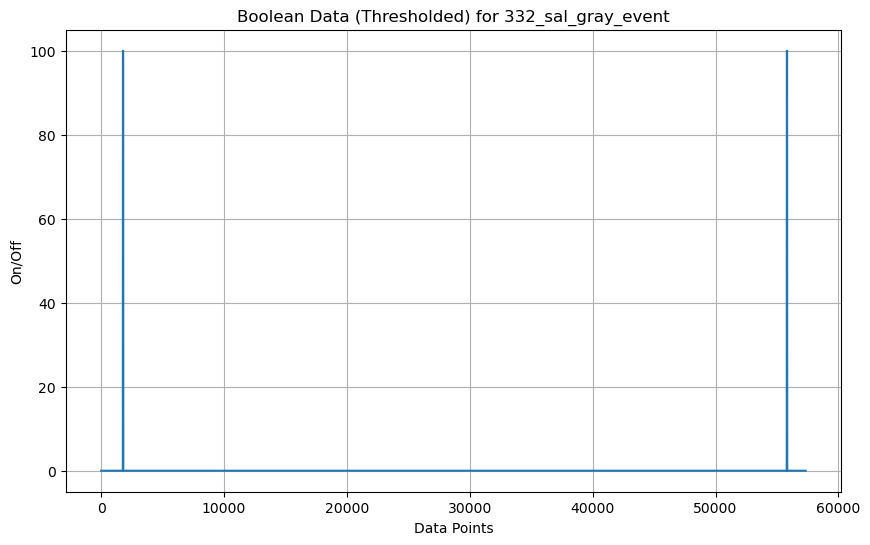

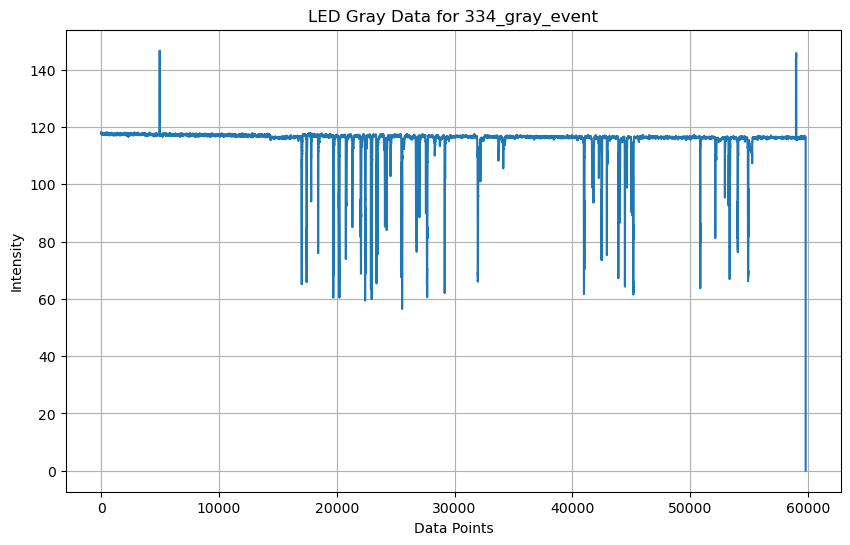

Please set the threshold for 334_gray_event based on the plot (e.g., 170): 140


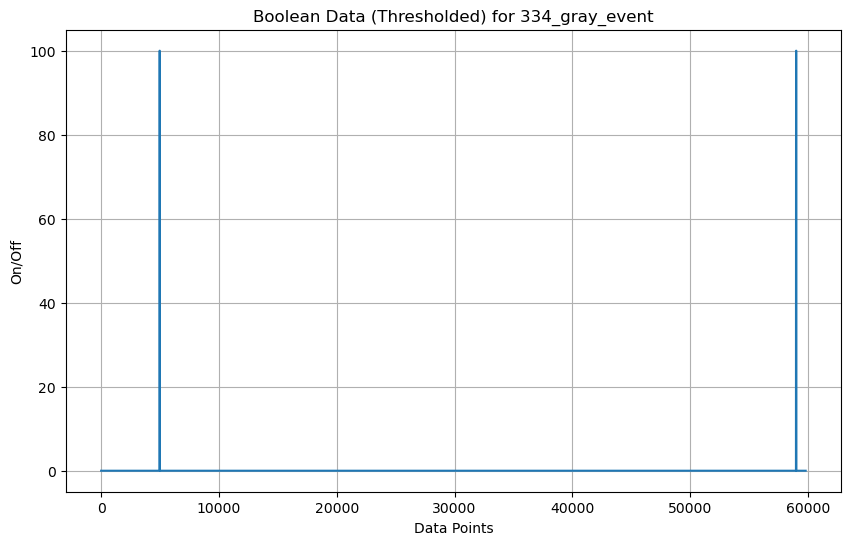

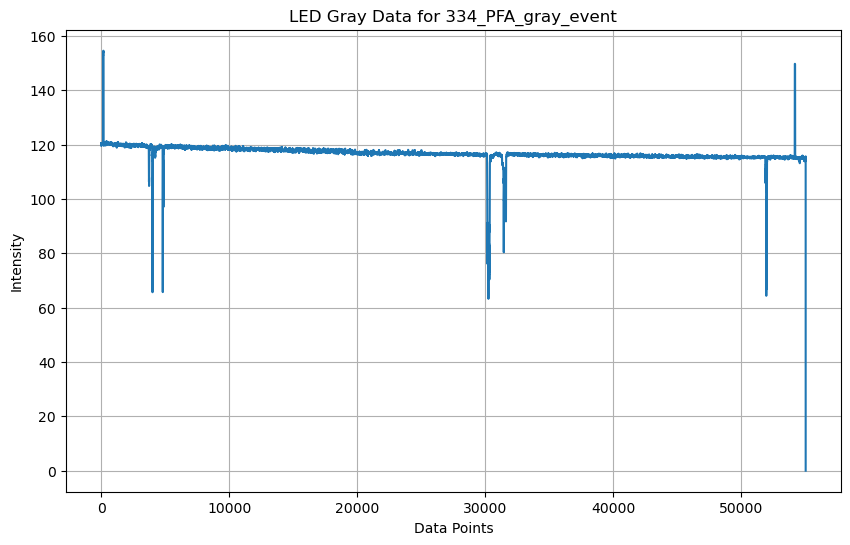

Please set the threshold for 334_PFA_gray_event based on the plot (e.g., 170): 140


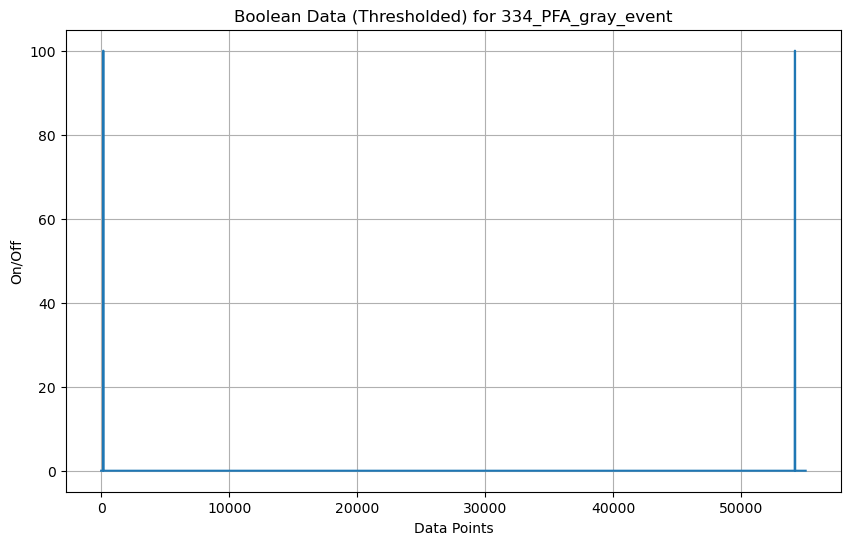

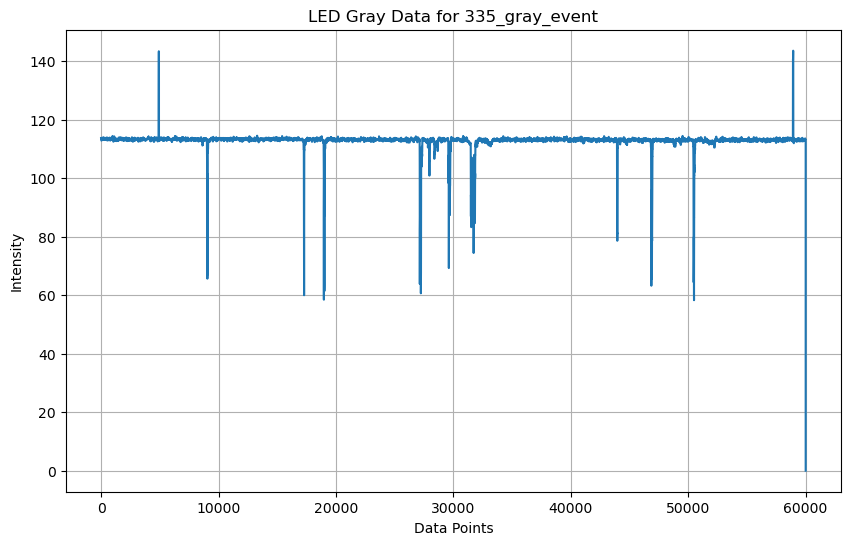

Please set the threshold for 335_gray_event based on the plot (e.g., 170): 140


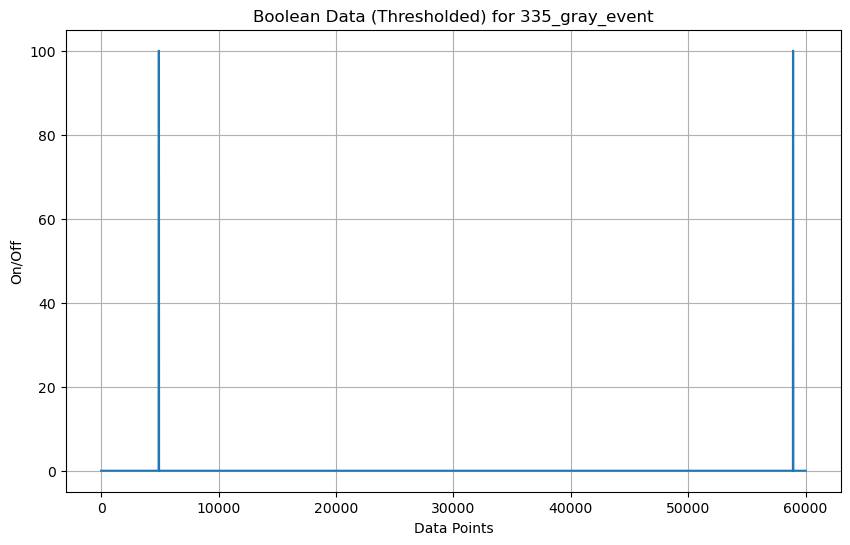

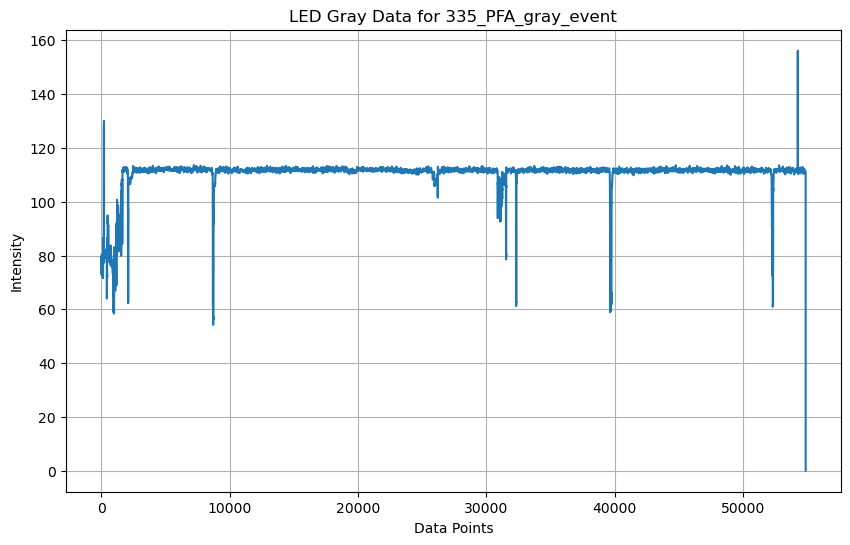

Please set the threshold for 335_PFA_gray_event based on the plot (e.g., 170): 120


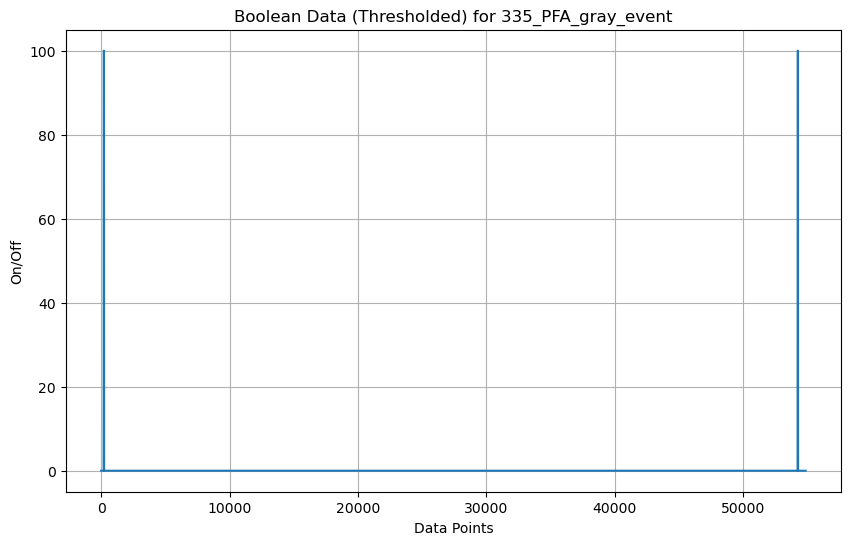

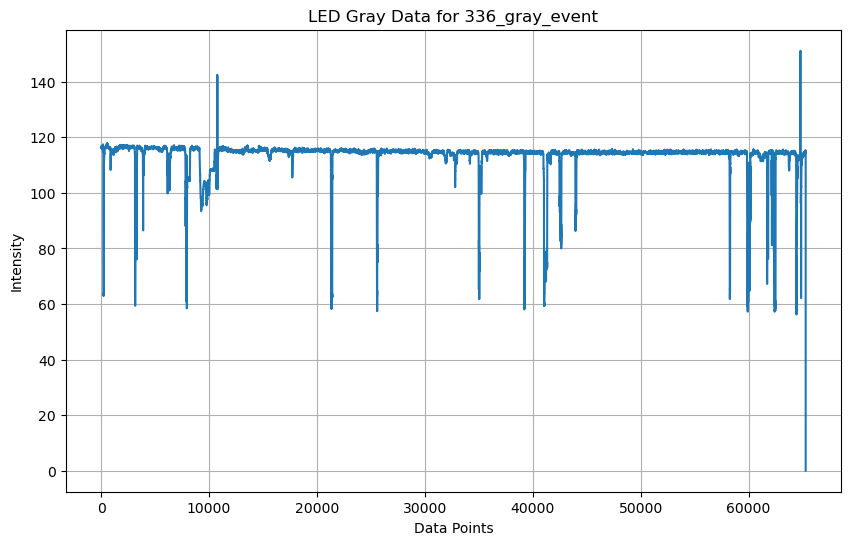

Please set the threshold for 336_gray_event based on the plot (e.g., 170): 140


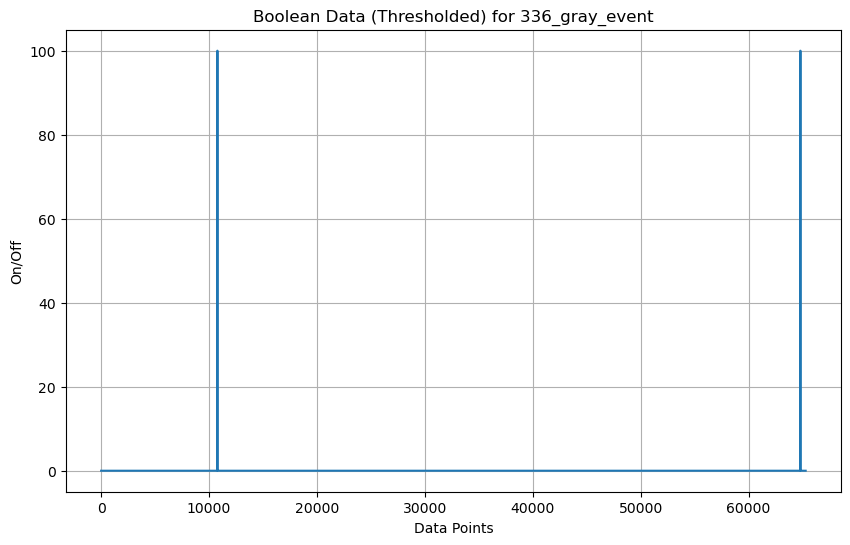

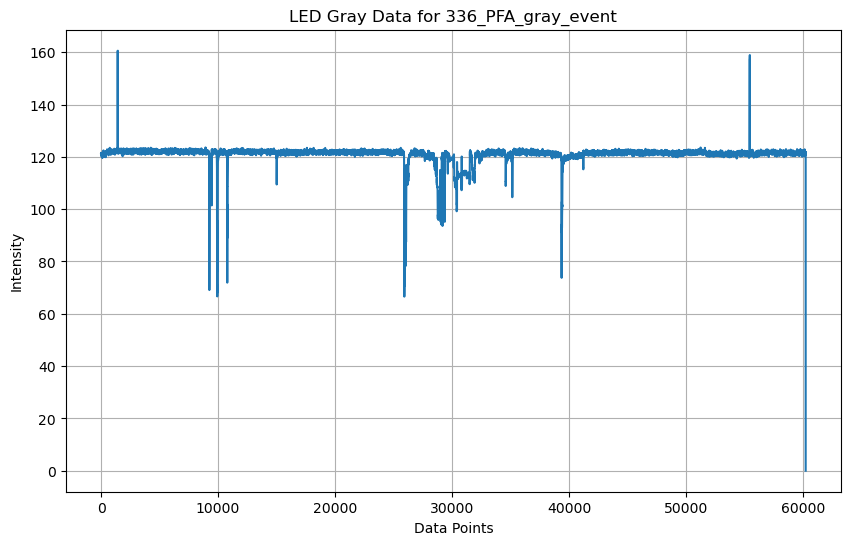

Please set the threshold for 336_PFA_gray_event based on the plot (e.g., 170): 140


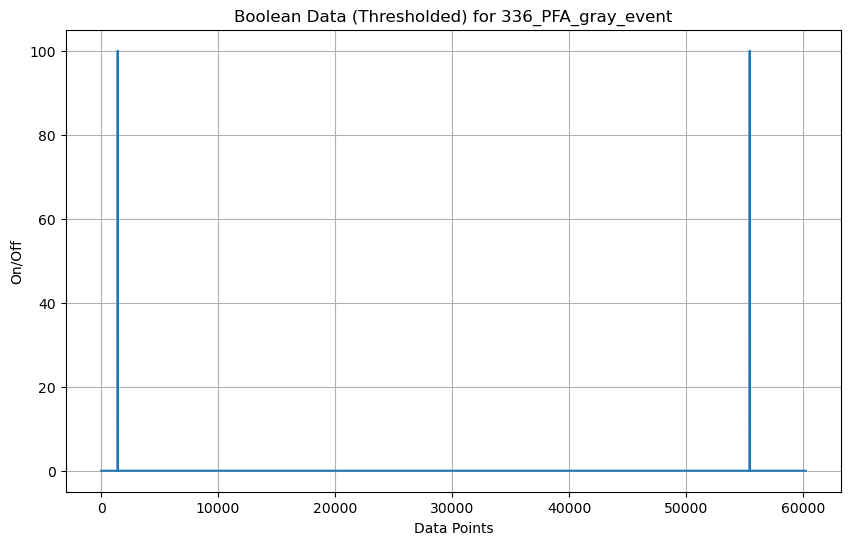

Offset_Point[0] | Onset_Point[1]
------------------------------
8576           | 62574
181           | 54180
379           | 54379
325           | 54324
330           | 54330
297           | 54297
5705           | 59704
182           | 54183
13205           | 67204
8233           | 62233
6087           | 60087
1795           | 55795
4982           | 58982
180           | 54181
4926           | 58924
225           | 54226
10785           | 64784
1429           | 55430


In [38]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Directory where the .npy files are located. Change if needed.
directory_path = '.'

# List all .npy files in the directory
all_files = [f for f in os.listdir(directory_path) if f.endswith('.npy')]

# Lists to store the offset_points[0] and onset_points[1] values
offset_points_values = []
onset_points_values = []

# Loop through all the .npy files
for file in all_files:
    # Load the data from the file
    led_gray = np.load(file)
    
    # Plot the data for inspection
    plt.figure(figsize=(10, 6))
    plt.plot(led_gray)
    filename_without_extension = os.path.splitext(file)[0]  # Remove .npy extension
    plt.title(f'LED Gray Data for {filename_without_extension}')
    plt.xlabel('Data Points')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Ask the user to set the threshold manually based on the plot
    threshold = float(input(f"Please set the threshold for {filename_without_extension} based on the plot (e.g., 170): "))
    
    # Process the data
    convert_start = 1
    convert_end = 1
    led_gray[:convert_start] = 0
    led_gray[-convert_end:] = 0
    data_bool = led_gray > threshold
    
    diff = np.diff(data_bool.astype(int))
    onset_points = np.where(diff == 1)[0] + 1
    offset_points = np.where(diff == -1)[0]
    
    # Append the desired values to their respective lists
    if len(offset_points) > 0:
        offset_points_values.append(offset_points[0])
    else:
        offset_points_values.append(None)
    
    if len(onset_points) > 1:
        onset_points_values.append(onset_points[1])
    else:
        onset_points_values.append(None)

    # Plot the boolean data
    plt.figure(figsize=(10, 6))
    plt.plot(data_bool * 100)
    plt.title(f'Boolean Data (Thresholded) for {filename_without_extension}')
    plt.xlabel('Data Points')
    plt.ylabel('On/Off')
    plt.grid(True)
    plt.show()

# Combine the two lists into an array and print
combined_array = np.array([offset_points_values, onset_points_values]).T

# Print the array as a table
print("Offset_Point[0] | Onset_Point[1]")
print("-" * 30)
for row in combined_array:
    print(f"{row[0]}           | {row[1]}")


In [39]:
combined_array[:,1] - combined_array[:,0]

array([53998, 53999, 54000, 53999, 54000, 54000, 53999, 54001, 53999,
       54000, 54000, 54000, 54000, 54001, 53998, 54001, 53999, 54001],
      dtype=int64)

In [40]:
combined_array

array([[ 8576, 62574],
       [  181, 54180],
       [  379, 54379],
       [  325, 54324],
       [  330, 54330],
       [  297, 54297],
       [ 5705, 59704],
       [  182, 54183],
       [13205, 67204],
       [ 8233, 62233],
       [ 6087, 60087],
       [ 1795, 55795],
       [ 4982, 58982],
       [  180, 54181],
       [ 4926, 58924],
       [  225, 54226],
       [10785, 64784],
       [ 1429, 55430]], dtype=int64)

In [41]:
all_files

['322_gray_event.npy',
 '322_sal_gray_event.npy',
 '326_gray_event.npy',
 '326_PFA_gray_event.npy',
 '327_gray_event.npy',
 '327_PFA_gray_event.npy',
 '328_gray_event.npy',
 '328_sal_gray_event.npy',
 '330_gray_event.npy',
 '330_sal_gray_event.npy',
 '332_gray_event.npy',
 '332_sal_gray_event.npy',
 '334_gray_event.npy',
 '334_PFA_gray_event.npy',
 '335_gray_event.npy',
 '335_PFA_gray_event.npy',
 '336_gray_event.npy',
 '336_PFA_gray_event.npy']

In [51]:
import pandas as pd
# Convert to DataFrame
df = pd.DataFrame(combined_array, columns=['Start', 'End'])
df['Frames'] = df['End'] - df['Start']

df['Filename'] = all_files
df['Filename'] = df['Filename'].str.replace('_gray_event.npy', '')
# Display the table
df

,Start,End,Frames,Filename
0,8576,62574,53998,322
1,181,54180,53999,322_sal
2,379,54379,54000,326
3,325,54324,53999,326_PFA
4,330,54330,54000,327
5,297,54297,54000,327_PFA
6,5705,59704,53999,328
7,182,54183,54001,328_sal
8,13205,67204,53999,330
9,8233,62233,54000,330_sal


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

results = []

# Search for all .npy files in the current directory
files = [f for f in os.listdir() if f.endswith('_gray_event.npy')]

for file in files:
    led_gray = np.load(file)
    
    # Define the amount of data to discard from the beginning and end
    convert_start = 1  # discard the first data point
    convert_end = 1  # discard the last data point

    # Convert the noise from the data to 0
    led_gray[:convert_start] = 0
    led_gray[-convert_end:] = 0

    # Find local maxima
    peaks, _ = find_peaks(led_gray, distance=53000)
    
    # If less than 2 peaks are found, we can't proceed with this logic
    if len(peaks) < 2:
        print(f"File {file} doesn't have enough peaks.")
        continue
    
    # Find the two highest peaks
    highest_peaks = sorted(peaks, key=lambda x: led_gray[x], reverse=True)[:2]
    highest_peaks.sort()  # sort the indices

    offset_point = highest_peaks[0]
    onset_point = highest_peaks[1]
    
    results.append([file, offset_point, onset_point])

# Display results in table format
print("\nResults:")
print("Filename\t\tOffset Point\tOnset Point")
for r in results:
    print(f"{r[0]}\t{r[1]}\t{r[2]}")

# Save results to Excel
df = pd.DataFrame(results, columns=["Filename", "Offset Point", "Onset Point"])
df.to_excel("analysis_results.xlsx", index=False)


In [20]:
import matplotlib.pyplot as plt

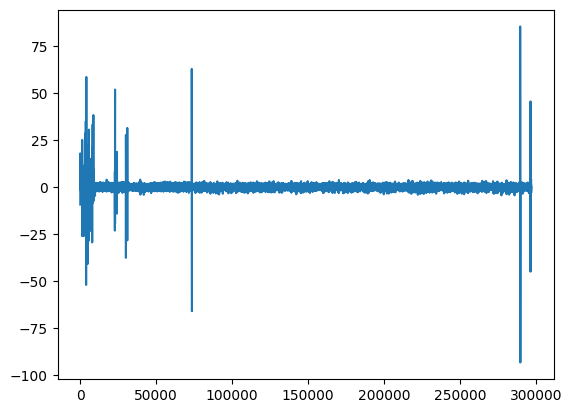

In [23]:
plt.plot(np.diff(np.load('led_event.npy')))

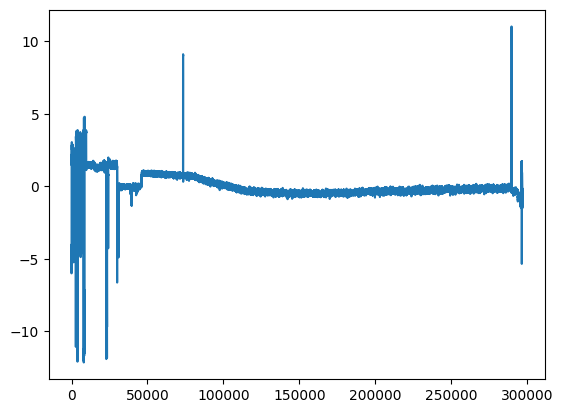

In [34]:
import numpy as np

data = np.load('led_event.npy')
normalized_data = (data - np.mean(data)) / np.std(data)
plt.plot(normalized_data)